In [1]:
import src.pre_processing as pp
import src.plots as plts
import src.VaeA as vA
import src.Resnet18 as rn

import numpy as np
import matplotlib.pyplot as plt

### resize images to 128x128

In [2]:
X, Y, Z, proba = pp.get_data()

### Split train, validation, test

In [3]:
X_train, Y_train, Z_train, X_val, Y_val, Z_val, X_test, Y_test, Z_test = pp.split_data(X, Y, Z)

In [4]:
X_train.shape, X_val.shape, X_test.shape

((2099, 128, 128), (262, 128, 128), (263, 128, 128))

## Geometric Augmentation

In [5]:
X_train_aug, Y_train_aug, Z_train_aug = pp.augment_data(X_train, Y_train, Z_train)

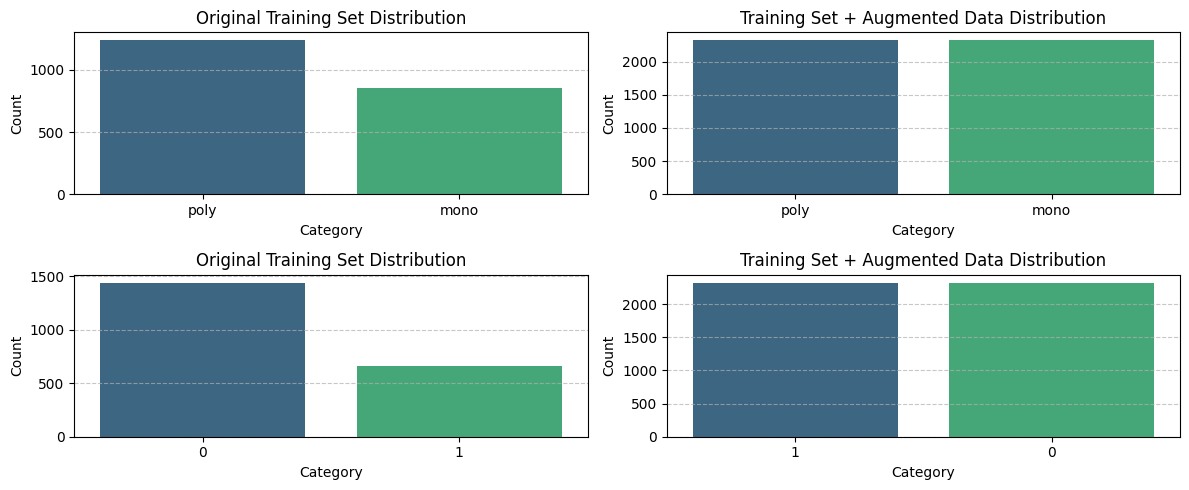

In [6]:
# compare the training set and the training + augmented set distributions
# first concatenate the original and augmented data
X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_combined = np.concatenate((Y_train, Y_train_aug), axis=0)
Z_train_combined = np.concatenate((Z_train, Z_train_aug), axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plts.plot_distribution(Z_train, 'Original Training Set Distribution', axs[0,0])
plts.plot_distribution(Z_train_combined, 'Training Set + Augmented Data Distribution', axs[0,1])
plts.plot_distribution(Y_train, 'Original Training Set Distribution', axs[1,0])
plts.plot_distribution(Y_train_combined, 'Training Set + Augmented Data Distribution', axs[1,1])
plt.tight_layout()
plt.show()

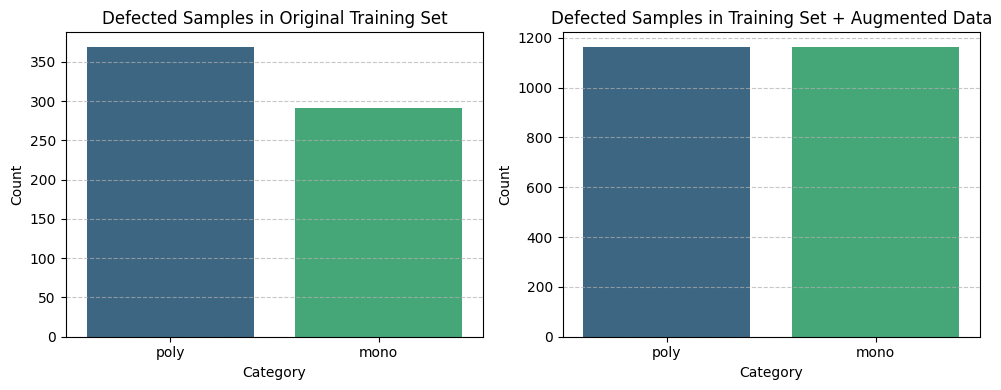

In [7]:
# among the defected samples Y=1 plot the distribution Z=mono Z=poly
Z_train_defected = Z_train[Y_train == 1]
Z_train_combined_defected = Z_train_combined[Y_train_combined == 1]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Z_train_defected, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Z_train_combined_defected, 'Defected Samples in Training Set + Augmented Data', axs[1])
plt.tight_layout()
plt.show() 

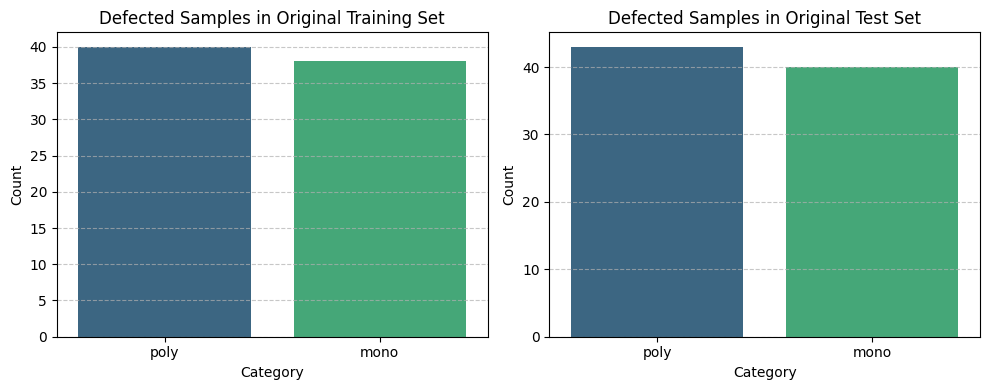

In [8]:
# among the defected samples Y=1 plot the distribution Z=mono Z=poly
Z_val_defected = Z_val[Y_val == 1]
Z_test_defected = Z_test[Y_test == 1]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Z_val_defected, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Z_test_defected, 'Defected Samples in Original Test Set', axs[1])
plt.tight_layout()
plt.show() 

# Generation

the best VAE is the A with latent dimension of 128, trained with no weigh decay, $\beta$ annealing approach, MSE as reconstruction loss.


To generate data (and to train VAE) we need to separate the defect examples

In [9]:
X_train_aug, Y_train_aug, Z_train_aug = pp.augment_data(X_train, Y_train, Z_train)

X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_combined = np.concatenate((Y_train, Y_train_aug), axis=0)
Z_train_combined = np.concatenate((Z_train, Z_train_aug), axis=0)

X_train_vae = pp.get_defect(X_train_combined,Y_train_combined)
X_val_vae = pp.get_defect(X_val,Y_val)
X_test_vae = pp.get_defect(X_test,Y_test)

Z_train_vae = pp.get_defect(Z_train_combined,Y_train_combined)

Load the weights download it on google drive: https://drive.google.com/drive/folders/1rCzs0FLY0nW0CQRnHPsKPAmqpXf9Uzdv?usp=drive_link

In [10]:
import torch
# Initialize the model architecture first
path = 'vaeA_model_Beta_ann_weights.pth'
model = vA.VAE(latent_dim=128, img_channels=1)
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model.eval() # Set to evaluation mode

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=16384, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=16384, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (

In [11]:
X_healthy = X_train_combined[Y_train_combined==0]
X_gen = vA.generate_controlled_samples(model, X_train_vae, Z_train_vae, X_healthy ,n_samples=800, mode='spherical', threshold=9.0, device="cpu")
Y_gen = np.ones(X_gen.shape[0])

Calculating Healthy Centroid...
Centroid calculated. Filtering samples with Latent Distance < 9.0
Generated 100/800 images...
Generated 200/800 images...
Generated 300/800 images...
Generated 400/800 images...
Generated 500/800 images...
Generated 600/800 images...
Generated 700/800 images...
Generated 800/800 images...


## visualize generated images 

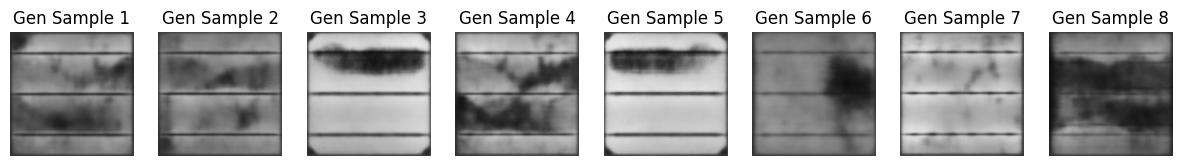

In [12]:
import random
i = random.randint(0, 200)
plts.visualize_augmentations(X_gen[i:,:,:], n_show=8)

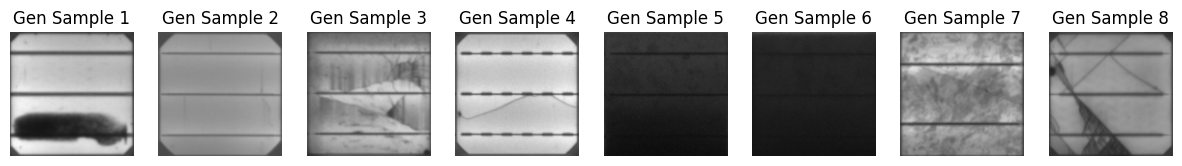

In [13]:
import random
i = random.randint(0, 700)
plts.visualize_augmentations(X_train_vae[i:,:,:], n_show=8)

## visualize interpolation

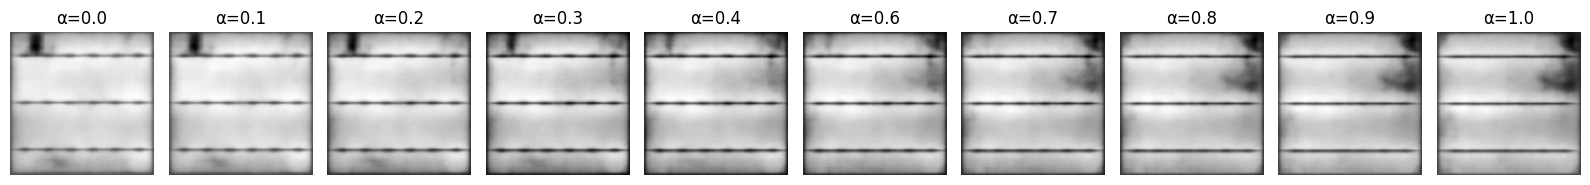

In [14]:
plts.visualize_interpolation(model, X_train_vae, n_steps=10, t=15)

# Final Training Scenarios

### (1) UNBALANCED 


In [15]:
X_train_1 = X_train
Y_train_1 = Y_train

### (2) UNBALANCED + GEOMETRIC AUGMENTATION

In [16]:
X_train_2 = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_2 = np.concatenate((Y_train, Y_train_aug), axis=0)

### (3) UNBALANCED + VAE AUGMENTATION

In [17]:
X_train_3 = np.concatenate((X_train, X_gen), axis=0)
Y_train_3 = np.concatenate((Y_train, Y_gen), axis=0)

#### See how also with the 3 scenarios we have a balanced dataset

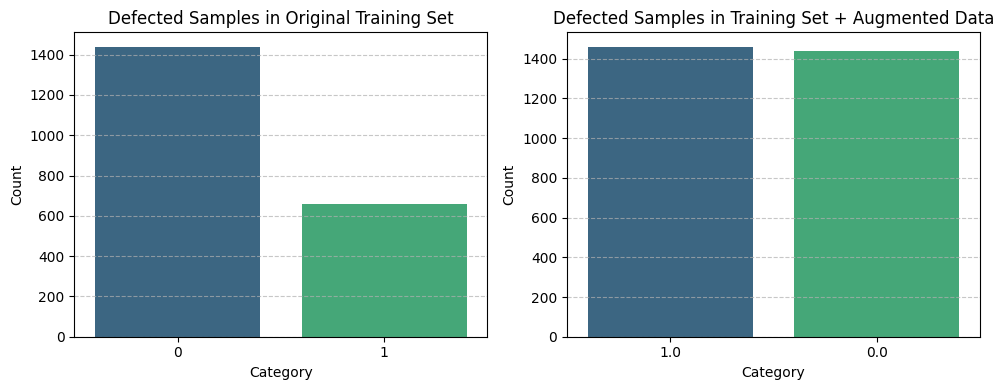

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Y_train, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Y_train_gen, 'Defected Samples in Training Set + Augmented Data', axs[1])
plt.tight_layout()
plt.show() 

## ResNet Trainings


In [19]:
model_1 = rn.ResNet18Binary(pretrained=True)

In [20]:
history_1, model_1 = rn.fine_tune_resnet(model_1, X_train_1, Y_train_1, X_val, Y_val, epochs=10, batch_size=32, lr=1e-4, weight_decay=1e-4, device="cpu")

Starting ResNet fine-tuning on cpu...
Epoch 1/10, Train Loss: 0.0142, Train Acc: 0.7894, Train Recall: 0.5879, Train Prec: 0.6953, Val Loss: 0.0135, Val Acc: 0.8015, Val Recall: 0.4615, Val Prec: 0.7826
Epoch 2/10, Train Loss: 0.0087, Train Acc: 0.8833, Train Recall: 0.7288, Train Prec: 0.8793, Val Loss: 0.0134, Val Acc: 0.8473, Val Recall: 0.7308, Val Prec: 0.7500
Epoch 3/10, Train Loss: 0.0056, Train Acc: 0.9290, Train Recall: 0.8606, Train Prec: 0.9088, Val Loss: 0.0137, Val Acc: 0.8168, Val Recall: 0.6282, Val Prec: 0.7206
Epoch 4/10, Train Loss: 0.0049, Train Acc: 0.9352, Train Recall: 0.8652, Train Prec: 0.9239, Val Loss: 0.0152, Val Acc: 0.8588, Val Recall: 0.6410, Val Prec: 0.8475
Epoch 5/10, Train Loss: 0.0031, Train Acc: 0.9667, Train Recall: 0.9424, Train Prec: 0.9511, Val Loss: 0.0214, Val Acc: 0.8321, Val Recall: 0.6667, Val Prec: 0.7429
Epoch 6/10, Train Loss: 0.0028, Train Acc: 0.9667, Train Recall: 0.9333, Train Prec: 0.9595, Val Loss: 0.0166, Val Acc: 0.8435, Val Recal

In [21]:
# test the model on the test set
Results_1 = rn.evaluate_resnet(model_1, X_test, Y_test, device="cpu")

Test Metrics - Accuracy: 0.8935, F1: 0.8250, Recall: 0.7952, Precision: 0.8571
